In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import optuna
import json

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Function to check dataset consistency
def check_data_integrity(df, name="Dataset"):
    print(f"Checking {name} integrity:")
    print("Shape:", df.shape)
    print("Missing values:", df.isnull().sum())
    print("Data types:", df.dtypes)
    print("-" * 40)

# Load training data
df = pd.read_csv("training_data.csv")
df.drop_duplicates(inplace=True)

# Ensure Model Year is not missing
df = df.dropna(subset=["Model Year"]).sort_values(by="Date", ascending=True).reset_index(drop=True)
df["Model Year"] = df["Model Year"].astype(int)

# Drop unnecessary columns
df = df.drop(columns="Region", axis=1)

# Convert categorical columns to category type
categorical_cols = ["Vehicle Category", "Fuel Type", "Fuel Technology", "Electric Mile Range"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

# Encode 'Number of Vehicles Registered at the Same Address'
df["Number of Vehicles Registered at the Same Address"] = df["Number of Vehicles Registered at the Same Address"].replace(
    {'1': 1, '2': 2, '3': 3, "≥4": 4, "Unknown": -1})

# Replace unknown values in 'GVWR Class'
df["GVWR Class"] = df["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

# Check integrity
check_data_integrity(df, "Training Data")

# Split into train and test sets
X = df.drop(columns="Vehicle Population")
y = df["Vehicle Population"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert 'GVWR Class' to categorical codes
X_train["GVWR Class"] = X_train["GVWR Class"].astype("category").cat.codes
X_test["GVWR Class"] = X_test["GVWR Class"].astype("category").cat.codes


Checking Training Data integrity:
Shape: (40450, 9)
Missing values: Date                                                 0
Vehicle Category                                     0
GVWR Class                                           0
Fuel Type                                            0
Model Year                                           0
Fuel Technology                                      0
Electric Mile Range                                  0
Number of Vehicles Registered at the Same Address    0
Vehicle Population                                   0
dtype: int64
Data types: Date                                                    int64
Vehicle Category                                     category
GVWR Class                                             object
Fuel Type                                            category
Model Year                                              int64
Fuel Technology                                      category
Electric Mile Range                     

In [2]:

# Load cleaned data for scoring
df1 = pd.read_csv("cleaned_data.csv", index_col=0)
df1 = df1.drop(columns="Region", axis=1)

# Convert categorical columns to category type
for col in categorical_cols:
    df1[col] = df1[col].astype("category")

df1["Number of Vehicles Registered at the Same Address"] = df1["Number of Vehicles Registered at the Same Address"].replace(
    {'1': 1, '2': 2, '3': 3, "≥4": 4, "Unknown": -1})

df1["GVWR Class"] = df1["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

# Check integrity
check_data_integrity(df1, "Cleaned Data")

# Separate features and target variable
X_scoring = df1.drop(columns="Vehicle Population", errors="ignore")
y_scoring = df1["Vehicle Population"] if "Vehicle Population" in df1 else None

# Convert 'GVWR Class' to categorical codes
X_scoring["GVWR Class"] = X_scoring["GVWR Class"].astype("category").cat.codes


Checking Cleaned Data integrity:
Shape: (40450, 9)
Missing values: Date                                                 0
Vehicle Category                                     0
GVWR Class                                           0
Fuel Type                                            0
Model Year                                           0
Fuel Technology                                      0
Electric Mile Range                                  0
Number of Vehicles Registered at the Same Address    0
Vehicle Population                                   0
dtype: int64
Data types: Date                                                    int64
Vehicle Category                                     category
GVWR Class                                             object
Fuel Type                                            category
Model Year                                              int64
Fuel Technology                                      category
Electric Mile Range                      

In [3]:

# Hyperparameter tuning function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'subsample': trial.suggest_uniform('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 2.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 5.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 5.0),
        'random_state': 42
    }

    encoder = TargetEncoder(cols=categorical_cols)
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    X_train_encoded[categorical_cols] = encoder.fit_transform(X_train[categorical_cols], y_train)
    X_test_encoded[categorical_cols] = encoder.transform(X_test[categorical_cols])

    model = XGBRegressor(**params)
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Run Optuna tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)


[I 2025-02-01 18:43:39,489] A new study created in memory with name: no-name-6df7d055-b0e4-49d4-8cd7-fdb203e59b81
[I 2025-02-01 18:43:40,165] Trial 0 finished with value: 4586.23876395462 and parameters: {'max_depth': 10, 'learning_rate': 0.05029251061417349, 'n_estimators': 325, 'subsample': 0.6926308924165402, 'colsample_bytree': 0.7185924295999588, 'reg_alpha': 0.047706289027278755, 'reg_lambda': 2.452479351689478, 'gamma': 1.450571321459666}. Best is trial 0 with value: 4586.23876395462.
[I 2025-02-01 18:43:40,855] Trial 1 finished with value: 5223.2170163607025 and parameters: {'max_depth': 7, 'learning_rate': 0.014243576500144727, 'n_estimators': 495, 'subsample': 0.681114488248756, 'colsample_bytree': 0.7747400791161925, 'reg_alpha': 0.021424345019458817, 'reg_lambda': 0.10845952942324139, 'gamma': 2.734824449305658}. Best is trial 0 with value: 4586.23876395462.
[I 2025-02-01 18:43:41,286] Trial 2 finished with value: 5942.479953689369 and parameters: {'max_depth': 4, 'learning

In [4]:

# Save best hyperparameters
top_trials = sorted(study.trials, key=lambda x: x.value)[:3]
top_params = [trial.params for trial in top_trials]

with open("best_models.json", "w") as f:
    json.dump(top_params, f, indent=4)

print("Best parameters saved successfully.")


Best parameters saved successfully.


In [5]:

# Load best models and apply to scoring dataset
with open("best_models.json", "r") as f:
    best_params = json.load(f)

# Ensure categorical encoding is consistent
encoder = TargetEncoder(cols=categorical_cols)
X_train_encoded = X_train.copy()
X_train_encoded[categorical_cols] = encoder.fit_transform(X_train[categorical_cols], y_train)
scoring_encoded = X_scoring.copy()
scoring_encoded[categorical_cols] = encoder.transform(X_scoring[categorical_cols])

# Predict with best models
predictions = {}
rmse_scores = {}

for i, params in enumerate(best_params):
    model = XGBRegressor(**params)
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(scoring_encoded)
    predictions[f"Model_{i+1}"] = y_pred

    if y_scoring is not None:
        rmse = np.sqrt(mean_squared_error(y_scoring, y_pred))
        rmse_scores[f"Model_{i+1}"] = rmse
        print(f"Model {i+1} RMSE: {rmse}")

# Save predictions
pd.DataFrame(predictions).to_csv("predictions.csv", index=False)
print("Predictions saved successfully.")


Model 1 RMSE: 1737.1568725938369
Model 2 RMSE: 1977.0861134508027
Model 3 RMSE: 2125.9674268436006
Predictions saved successfully.


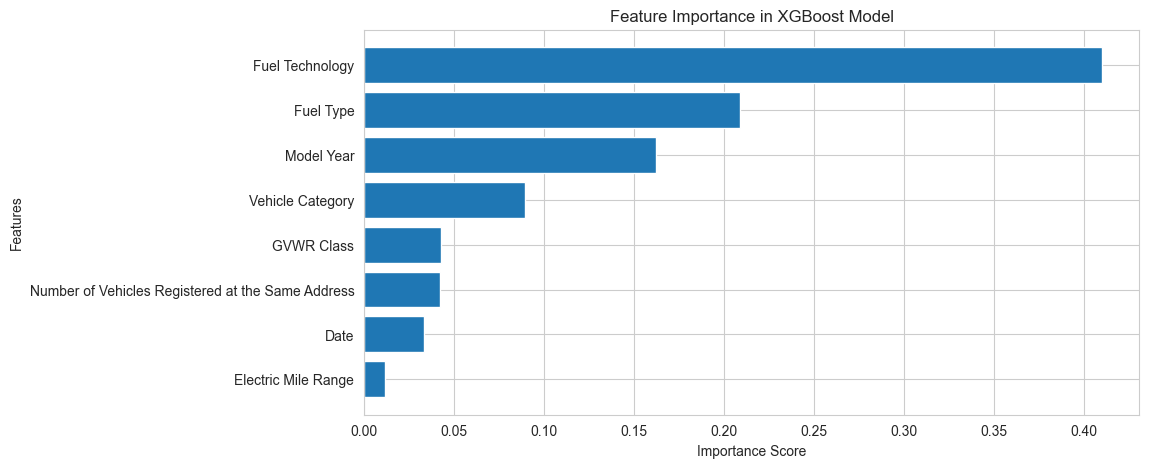

                                             Feature  Importance
5                                    Fuel Technology    0.409888
3                                          Fuel Type    0.208855
4                                         Model Year    0.161978
1                                   Vehicle Category    0.089613
2                                         GVWR Class    0.042500
7  Number of Vehicles Registered at the Same Address    0.041923
0                                               Date    0.033320
6                                Electric Mile Range    0.011922


In [6]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Train the model (ensure best_params is defined)
best_model = xgb.XGBRegressor(**best_params[0])
best_model.fit(X_train_encoded, y_train)

# Get feature importance
feature_importance = best_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # Flip the order
plt.show()

# Print top features
print(importance_df)


In [7]:
# Create a DataFrame to compare y_test and y_pred
comparison_df = pd.DataFrame({
    'Actual': y_scoring,
    'Predicted': y_pred
})

# Display the DataFrame
print(comparison_df.head(50))

    Actual      Predicted
0   395883  353945.968750
1       70      19.814842
2       70     -83.256516
3       70     269.747925
4       70      86.152603
5       70     200.319794
6       70     204.609528
7       70      46.146076
8       70     662.738342
9       69     249.228882
10      69     488.335693
11      70     180.036194
12      69      94.083290
13      69    -673.915527
14      69    -693.294067
15      69    -619.048218
16      69     449.002899
17      69    -150.397385
18      69     228.363297
19      69     216.342575
20      69     126.079727
21      69    -236.298218
22      69   -1552.867065
23      69     188.728683
24      69    -523.150452
25      70      42.421841
26      70     497.661316
27      72     162.982910
28      72     427.844543
29      72    -138.292816
30      71      27.451946
31      71     328.439484
32      71    -702.936157
33      71     453.804443
34      71     198.334900
35      71    -145.812683
36      71   -1061.690186
37      70  

In [8]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from category_encoders import TargetEncoder

# Ensure categorical encoding is consistent
encoder = TargetEncoder(cols=categorical_cols)
X_train_encoded = X_train.copy()
X_train_encoded[categorical_cols] = encoder.fit_transform(X_train[categorical_cols], y_train)

# Convert dataset into XGBoost's DMatrix format (improves efficiency)
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)

# Define K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform XGBoost cross-validation
cv_results = xgb.cv(
    best_params[0],  # Ensure this is a dictionary
    dtrain,
    num_boost_round=500,
    folds=kf,
    metrics="rmse",  # ✅ Correct metric for regression
    as_pandas=True,
    early_stopping_rounds=50,
    seed=42
)

# Print mean and standard deviation of RMSE across folds
mean_rmse = cv_results["test-rmse-mean"].iloc[-1]
std_rmse = cv_results["test-rmse-std"].iloc[-1]

print(f"Mean RMSE across folds: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

# Detect overfitting
if std_rmse > mean_rmse * 0.2:
    print("⚠️ Possible overfitting detected: High RMSE variance across folds!")
else:
    print("✅ Model appears to generalize well across folds.")

# Train the best model using full dataset
model = xgb.train(best_params[0], dtrain, num_boost_round=500)

# Predict on training data
y_train_pred = model.predict(dtrain)

# Compute RMSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {train_rmse:.4f}")

# Compare training and validation RMSE
if train_rmse < mean_rmse * 0.9:  # If training RMSE is much lower than validation RMSE
    print("⚠️ Possible overfitting detected: Training RMSE is significantly lower than validation RMSE!")
else:
    print("✅ Training and validation RMSE are consistent.")


Mean RMSE across folds: 4311.6995
Standard Deviation of RMSE: 605.3085
✅ Model appears to generalize well across folds.
Training RMSE: 485.9357
⚠️ Possible overfitting detected: Training RMSE is significantly lower than validation RMSE!


Predictions exported to 'model_predictions.csv' successfully.
0 RMSE: 2125.9674
RMSE results saved to 'rmse_comparison.csv'.


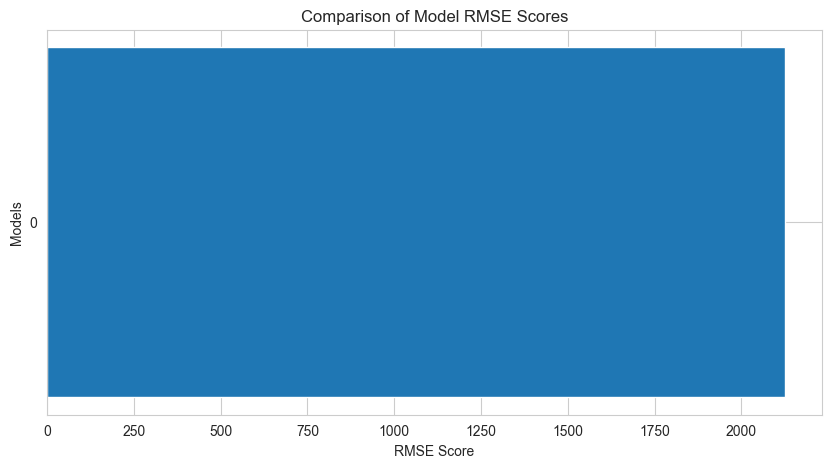

,Model,RMSE
0,0,2125.967408


In [14]:
# Save predictions to a separate CSV file
predictions_df = pd.DataFrame(y_pred)
predictions_df.to_csv("model_predictions.csv", index=False)
print("Predictions exported to 'model_predictions.csv' successfully.")

# Load the predictions from CSV
predictions_loaded = pd.read_csv("model_predictions.csv")

# Calculate RMSE for each model
rmse_comparison = {}
for i, col in enumerate(predictions_loaded.columns):
    rmse = np.sqrt(mean_squared_error(y_scoring, predictions_loaded[col]))
    rmse_comparison[col] = rmse
    print(f"{col} RMSE: {rmse:.4f}")

# Save RMSE comparison results
rmse_df = pd.DataFrame(list(rmse_comparison.items()), columns=["Model", "RMSE"])
rmse_df.to_csv("rmse_comparison.csv", index=False)
print("RMSE results saved to 'rmse_comparison.csv'.")

# Display RMSE values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(rmse_df["Model"], rmse_df["RMSE"])
plt.xlabel("RMSE Score")
plt.ylabel("Models")
plt.title("Comparison of Model RMSE Scores")
plt.gca().invert_yaxis()
plt.show()

# Print RMSE dataframe for reference
from IPython.display import display

display(rmse_df)
